# Init

In [1]:
from skfem import *
import numpy as np
from utils import *
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
from skfem.visuals.matplotlib import draw, plot
import sys
import time

tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 2
element_type = 'P1'
sigma = 5
penalty = False
# epsilon = 1e-5
example = 'ex4'
save_path = 'log/' + example + '_' + element_type + '_' + ('pen' if penalty else 'nopen') + '_' +'{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [2]:
def dirichlet(w):
    """return a harmonic function"""
    x = w[0]
    y = w[1]
    return (x**2 + y**2)**(5/6) * sin(5*atan(y / x)/3)

In [2]:
def solve_problem1(m, element_type='P1', solver_type='pcg', intorder=6, tol=1e-8, epsilon=1e-6):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }

    boundary_basis = FacetBasis(m, e)
    
    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))

    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh

#     uh0 = solve(*condense(K2, f2, D=easy_boundary(m, basis['u'])), solver=solver_iter_mgcg(tol=tol))
    uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg(tol=tol))

    return uh0, basis

# Solving

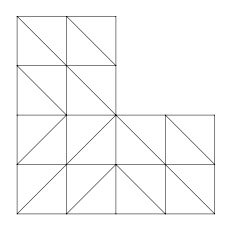

In [3]:
m = MeshTri().init_lshaped()
m.refine()
draw(m)

In [4]:
epsilon = 0
ep = epsilon

In [5]:
uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

In [6]:
uh0

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.46153846e-06,  3.46153846e-06,
        3.60576923e-06,  2.74038462e-06,  2.74038462e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.65384615e-07,
       -8.65384615e-07, -3.82666029e-21,  4.89535464e-06, -4.89535464e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.29286339e-22,  0.00000000e+00,  0.00000000e+00, -1.52857559e-22,
        0.00000000e+00,  0.00000000e+00, -1.59127519e-22,  0.00000000e+00,
        0.00000000e+00,  7.17575038e-22,  0.00000000e+00,  0.00000000e+00,
       -3.63291128e-22,  0.00000000e+00,  0.00000000e+00, -2.74038462e-06,
       -3.87548909e-06,  2.74038462e-06,  3.87548909e-06,  1.44230769e-07,
        7.21153846e-07,  

In [7]:
time_start = time.time()

print('=======Arguments=======')
print('penalty:\t{}'.format(penalty))
print('element_type:\t{}'.format(element_type))
print('solver_type:\t{}'.format(solver_type))
print('tol:\t{}'.format(tol))
print('intorder:\t{}'.format(intorder))
print('refine_time:\t{}'.format(refine_time))
print('sigma:\t{}'.format(sigma))
print('=======Results=======')

df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri().init_lshaped()
#     draw(m)

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis, fbasis = solve_problem2(m, element_type, solver_type, intorder, tol, epsilon)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        if penalty:
            D2u = np.sqrt(get_D2uError(basis['u'], uh0)**2 + L2pnvError.assemble(fbasis, w=fbasis.interpolate(uh0)))
        else:
            D2u = get_D2uError(basis['u'], uh0)
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilion:', epsilon)
    show_result(L2s, H1s, H2s, epus)

time_end = time.time()

result = df_list[0].append(df_list[1:])
result.to_csv(save_path+'.csv')
print('======= Errors saved in:', save_path+'.csv ==========')
print('Total Time Cost {:.2f} s'.format(time_end-time_start))

=======Arguments=======
penalty:	False
element_type:	P1
solver_type:	mgcg
tol:	1e-08
intorder:	5
refine_time:	5
sigma:	5
=======Results=======
epsilion: 1
  h    L2u   H1u   H2u   epu
2^-2  -0.00  -0.00  -0.00  -0.00
2^-2  1.160e+00  3.615e+00  6.805e+00  4.025e+00
2^-3  -0.00  -0.00  -0.00  -0.00
2^-3  1.160e+00  3.615e+00  6.807e+00  4.027e+00
2^-4  -0.00  -0.00  -0.00  -0.00
2^-4  1.160e+00  3.615e+00  6.808e+00  4.028e+00
2^-5  0.00  -0.00  -0.00  -0.00
2^-5  1.160e+00  3.615e+00  6.809e+00  4.028e+00
epsilion: 0.1
  h    L2u   H1u   H2u   epu
2^-2  -0.00  -0.00  -0.00  -0.00
2^-2  1.160e+00  3.615e+00  6.805e+00  2.475e+00
2^-3  0.00  -0.00  -0.00  -0.00
2^-3  1.160e+00  3.615e+00  6.807e+00  2.475e+00
2^-4  0.00  -0.00  -0.00  -0.00
2^-4  1.160e+00  3.615e+00  6.808e+00  2.475e+00
2^-5  0.00  -0.00  -0.00  -0.00
2^-5  1.160e+00  3.615e+00  6.809e+00  2.475e+00
======= Errors saved in: log/ex4_P1_nopen_2021-01-16_21-08-02.csv ==========
Total Time Cost 2.24 s
